# Fast GP implementations

## Benchmarking our implementation
Let's do some timing tests and compare them to what we get with two handy GP packages: ``george`` and ``celerite``. We'll learn how to use both along the way.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1a</h1>
</div>

Let's time how long our custom implementation of a GP takes for a rather long dataset. Create a time array of ``10,000`` points between 0 and 10 and time how long it takes to sample the prior of the GP for the default kernel parameters (unit amplitude and timescale). Add a bit of noise to the sample and then time how long it takes to evaluate the log likelihood for the dataset. Make sure to store the value of the log likelihood for later.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1b</h1>
</div>

Let's time how long it takes to do the same operations using the ``george`` package (``pip install george``).

The kernel we'll use is

```python
kernel = amp ** 2 * george.kernels.ExpSquaredKernel(tau ** 2)
```

where ``amp = 1`` and ``tau = 1`` in this case.

To instantiate a GP using ``george``, simply run

```python
gp = george.GP(kernel)
```

The ``george`` package pre-computes a lot of matrices that are re-used in different operations, so before anything else, ask it to compute the GP model for your timeseries:

```python
gp.compute(t, sigma)
```

Note that we've only given it the time array and the uncertainties, so as long as those remain the same, you don't have to re-compute anything. This will save you a lot of time in the long run!

Finally, the log likelihood is given by ``gp.log_likelihood(y)`` and a sample can be drawn by calling ``gp.sample()``.

How do the speeds compare? Did you get the same value of the likelihood (assuming you computed it for the same sample in both cases)?

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1c</h1>
</div>

``george`` offers a fancy GP solver called the HODLR solver, which makes some approximations that dramatically speed up the matrix algebra. Instantiate the GP object again by passing the keyword ``solver=george.HODLRSolver`` and re-compute the log likelihood. How long did that take?

(I wasn't able to draw samples using the HODLR solver; unfortunately this may not be implemented.)

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 2</h1>
</div>

The ``george`` package is super useful for GP modeling, and I recommend you read over the [docs and examples](https://george.readthedocs.io/en/latest/). It implements several different [kernels](https://george.readthedocs.io/en/latest/user/kernels/) that come in handy in different situations, and it has support for multi-dimensional GPs. But if all you care about are GPs in one dimension (in this case, we're only doing GPs in the time domain, so we're good), then ``celerite`` is what it's all about:

```bash
pip install celerite
```

Check out the [docs](https://celerite.readthedocs.io/en/stable/) here, as well as several tutorials. There is also a [paper](https://arxiv.org/abs/1703.09710) that discusses the math behind ``celerite``. The basic idea is that for certain families of kernels, there exist **extremely efficient** methods of factorizing the covariance matrices. Whereas GP fitting typically scales with the number of datapoints $N$ as $N^3$, ``celerite`` is able to do everything in order $N$ (!!!) This is a **huge** advantage, especially for datasets with tens or hundreds of thousands of data points. Using ``george`` or any homebuilt GP model for datasets larger than about ``10,000`` points is simply intractable, but with ``celerite`` you can do it in a breeze.

Repeat the timing tests, but this time using ``celerite``. Note that the Exponential Squared Kernel is not available in ``celerite``, because it doesn't have the special form needed to make its factorization fast. Instead, use the ``Matern 3/2`` kernel, which is qualitatively similar, and which can be approximated quite well in terms of the ``celerite`` basis functions:

```python
kernel = celerite.terms.Matern32Term(np.log(1), np.log(1))
```

Note that ``celerite`` accepts the **log** of the amplitude and the **log** of the timescale. Other than this, you should be able to compute the likelihood and draw a sample with the same syntax as ``george``.

How much faster did it run?

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 3</h1>
</div>

Let's use ``celerite`` for a real application: fitting an exoplanet transit model in the presence of correlated noise.

Below is a (fictitious) light curve for a star with a transiting planet. There is a transit visible to the eye at $t = 0$, which (say) is when you'd expect the planet to transit if its orbit were perfectly periodic. However, a recent paper claims that the planet shows transit timing variations, which are indicative of a second, perturbing planet in the system, and that a transit at $t = 0$ can be ruled out at 3 $\sigma$. Your task is to verify this claim.

Assume you have no prior information on the planet other than the transit occurs in the observation window, the depth of the transit is somewhere in the range $(0, 1)$, and the transit duration is somewhere between $0.1$ and $1$ day. You don't know the exact process generating the noise, but you are certain that there's correlated noise in the dataset, so you'll have to pick a reasonable kernel and estimate its hyperparameters.


Fit the transit with a simple inverted Gaussian with three free parameters:

```python
def transit_shape(depth, t0, dur):
    return -depth * np.exp(-0.5 * (t - t0) ** 2 / (0.2 * dur) ** 2)
```

Read the celerite docs to figure out how to solve this problem efficiently. 

*HINT: I borrowed heavily from [this tutorial](https://celerite.readthedocs.io/en/stable/tutorials/modeling/), so you might want to take a look at it...*

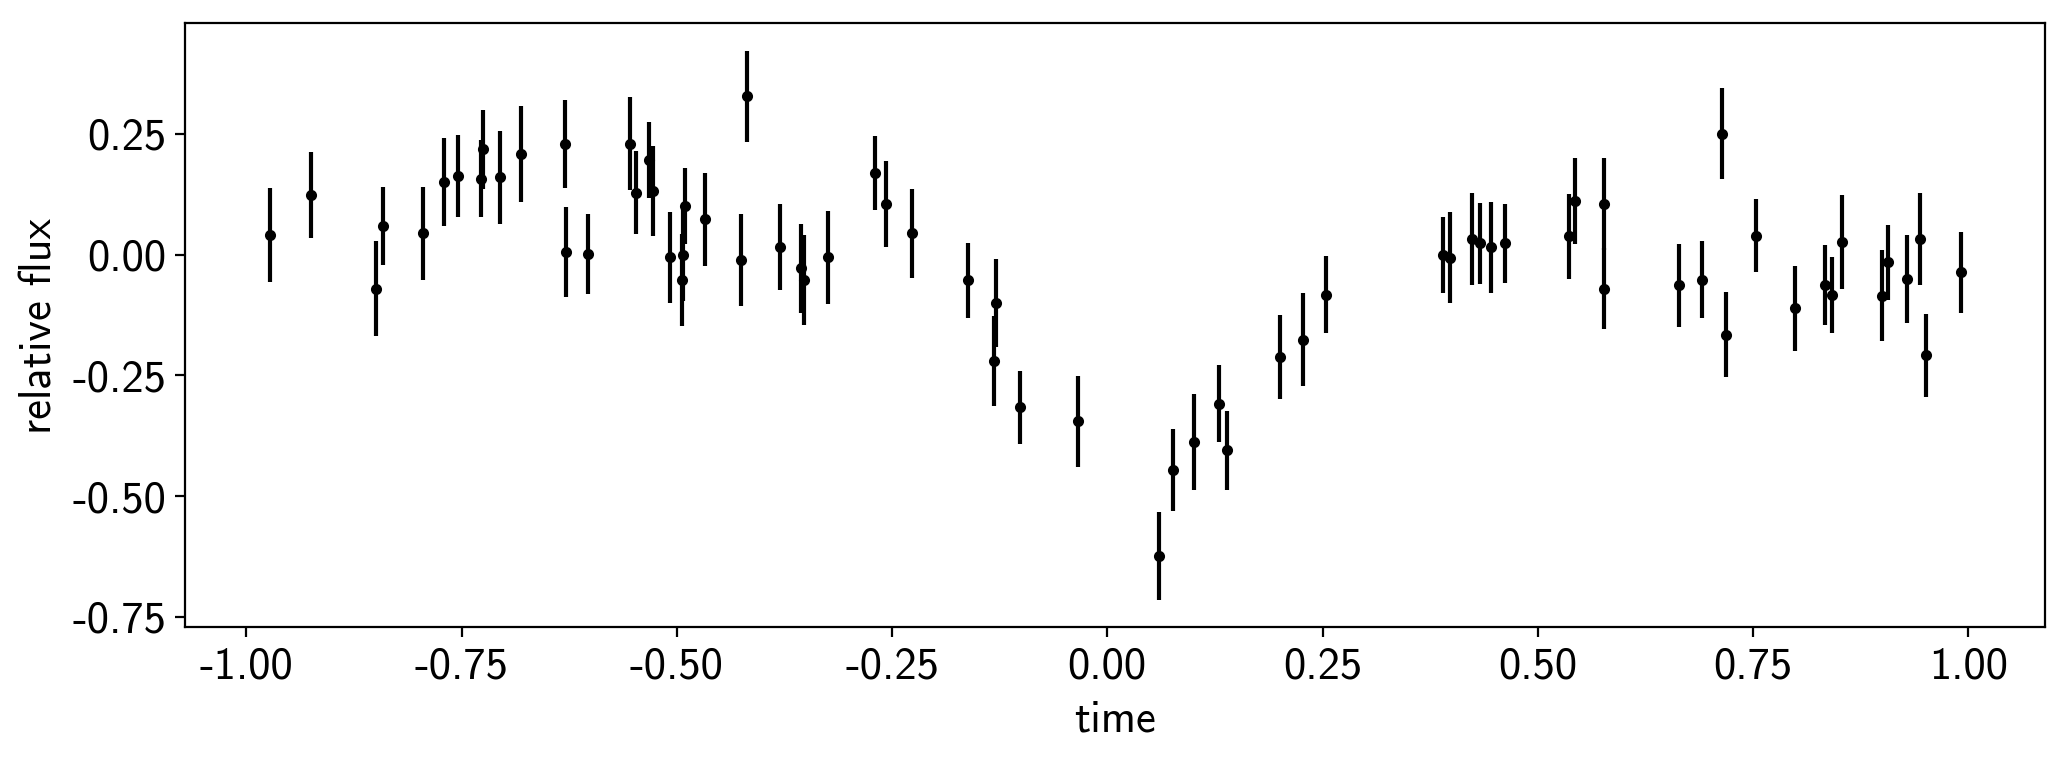

In [19]:
import matplotlib.pyplot as plt
t, y, yerr = np.loadtxt("data/sample_transit.txt", unpack=True)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("time")
plt.ylabel("relative flux");